In [1]:
import numpy as np
import gym
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L

/Users/nishiokakentaro/Desktop/py-playground/cartpole/.venv/lib/python3.9/site-packages/dezero/transforms.py:154: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, dtype=np.int):


In [2]:
class Policy(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.softmax(self.l2(x))
        return x

In [3]:
class Agent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0002
        self.action_size = 2

        self.memory = []
        self.pi = Policy(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.pi)

    def get_action(self, state):
        # バッチの軸を追加
        state = state[np.newaxis, :]
        # Policyのforward関数を呼び出し
        probs = self.pi(state)
        # バッチ次元の削除
        probs = probs[0]
        
        action = np.random.choice(len(probs), p=probs.data)
        return action, probs[action]

    def add(self, reward, prob):
        data = (reward, prob)
        self.memory.append(data)

    def update(self):
        self.pi.cleargrads()

        G, loss = 0.0, 0.0
        for reward, prob in reversed(self.memory):
            G = reward + self.gamma * G
            loss += -F.log(prob) * G

        loss.backward()
        self.optimizer.update()
        self.memory = []

In [4]:
episodes = 3000
env = gym.make('CartPole-v0')
agent = Agent()
reward_history = []

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, prob = agent.get_action(state)
        next_state, reward, done, info = env.step(action)

        agent.add(reward, prob)
        state = next_state
        total_reward += reward

    agent.update()
    reward_history.append(total_reward)

/Users/nishiokakentaro/Desktop/py-playground/cartpole/.venv/lib/python3.9/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/nishiokakentaro/Desktop/py-playground/cartpole/.venv/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/nishiokakentaro/Desktop/py-playground/cartpole/.venv/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


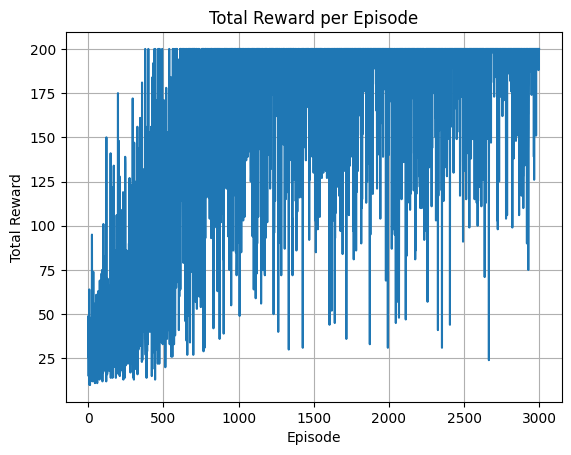

In [5]:
import matplotlib.pyplot as plt

plt.plot(reward_history)
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()